In [19]:
#################### Params ###############

NOVA_HOME = '/home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA'
preprocessing_path = "/home/labs/hornsteinlab/Collaboration/FUNOVA/outputs/preprocessing/brenner"
csv_name = 'raw_metrics260225_exp4_processed.csv'
# site_csv_name = 'raw_metrics250225_exp3_processed.csv'
mappings_filepath = "/home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA/manuscript/markers_focus_boundries/markers_focus_boundries_funova_Exp4_tiles.csv"
imgs_path = '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/'

metric_name = 'Target_Sharpness_Brenner'
img_shape = 1024
tile_shape = [100, 100]
percentiles_resolution = 0.0001
percentile_ranges_for_reports = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 30, 40, 60, 75, 80, 85, 90, 95, 98, 99, 99.5, 99.7, 99.8,99.9,100]

In [20]:
import os
import sys
import concurrent.futures
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec

os.environ['NOVA_HOME'] = NOVA_HOME
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from src.preprocessing.preprocessing_utils import get_image_focus_quality, crop_image_to_tiles, rescale_intensity, fit_image_shape

%reload_ext autoreload
%autoreload 2
%aimport

%matplotlib inline

NOVA_HOME: /home/labs/hornsteinlab/Collaboration/NOVA_GAL/NOVA
Modules to reload:
all-except-skipped

Modules to skip:



# Utils

In [21]:
def get_metrics(tile, as_string=False):
    sharpness_brenner = get_image_focus_quality(tile)    
    if as_string:
        return f"Brenner: {round(sharpness_brenner, 3)}"
    return sharpness_brenner

def show_images(df, max_samples = 10, show_tile = False):
    for ind, path in enumerate(df.Path.values):
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        target_path = os.path.join(imgs_path, path)
        tile_index = df['Tile'].iloc[ind]
        print(ind, tile_index, target_path)
#         show_processed_tif(target_path)
#         x,y = get_tile_location(tile_index, [img_shape, img_shape], tile_shape)
#         plt.gca().add_patch(plt.Rectangle((x, y), tile_shape[0], tile_shape[1], edgecolor='red', linewidth=2, fill=False))
#         plt.show()
        
        if show_tile:
            img = np.load(path)
            img = img[tile_index]
            target_img = img[:, :, 0]
            nuc_img = img[:, :, 1]
            print("SNR:", compute_snr(img))
            print("Entropy:", compute_entropy(img))
            labels = show_label(path)
            perc_brenner = abs(percentiles[[per for per in percentiles.keys() if '%' in per]] - get_image_focus_quality(target_img)).idxmin()
            
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].set_title(f"{tile_index}: {labels[1]}, {labels[3]}, {get_metrics(target_img, True)}, {perc_brenner}", color='purple', fontsize=10)
            ax[0].imshow(target_img, cmap='gray', vmin=0, vmax=1)
            ax[0].set_axis_off()

            ax[1].set_title(f'Nucleus, Brenner: {get_metrics(nuc_img, True)}', fontsize=10)
            ax[1].imshow(nuc_img, cmap='gray', vmin=0, vmax=1)
            ax[1].set_axis_off()
            
            plt.show()
        # His DAPI
        # path_l = target_path.split("/")
        # path_l[-2] = 'DAPI'
        
        # file_name = path_l[-1].split("_")
        # dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        # dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        # print(dapi_file_name)

        # show_processed_tif(dapi_file_name)
        print('--------------------------------')
        
def init_mappings(markers=[], filepath=None):
    if filepath is not None:     
        if os.path.exists(filepath):
            mappings = pd.read_csv(filepath, index_col=0)
            return mappings
        
    mappings = pd.DataFrame(columns=['Lower_bound'], index=markers)

    return mappings
        
def save_to_mapping(filepath, mappings, marker, value, is_upper_bound):
    col = 'Upper_bound' if is_upper_bound else 'Lower_bound' 
    mappings.loc[marker, col] = value
    
    mappings.to_csv(filepath)
    print(f"File saved to {filepath}")

def show_label(path):
    path_l = path.split("/")
    return path_l[-7:]

def process_tif(path):
    """
    Read and process the image.

    Parameters:
        path (str): Path to the image file.

    Returns:
        ndarray: Processed image.
    """
    # read the image stack
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    img = fit_image_shape(img, (img_shape, img_shape))
    # rescale pixel intensities
    img = rescale_intensity(img)
    return img
    
def show_processed_tif(path):
    img = process_tif(path)
    print(get_metrics(img, True))
    # show the image with grid 
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(path), color='purple')
    print(f"Img shape: {img.shape}")

def put_tiles_grid(image, ax):
    # assumes 1000x1000 image
    import matplotlib.patches as patches

    # Add dashed grid lines for 64 blocks
    num_blocks = 10
    block_size = 100

    for i in range(1, num_blocks):
        # Draw horizontal dashed lines
        ax.plot([0, 1000], [i * block_size, i * block_size], linestyle='--', lw=1, alpha=0.5, color='pink')

        # Draw vertical dashed lines
        ax.plot([i * block_size, i * block_size], [0, 1000], linestyle='--', lw=1, alpha=0.5, color='pink')

    # Remove x and y axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a title
    plt.title('Image with Dashed Grid of 64 Blocks')

def update_all_mappings(mappings: pd.DataFrame, thresholds: dict) -> pd.DataFrame:
    for marker, value in thresholds.items():
        if marker in mappings.index:
            mappings.loc[marker, "Lower_bound"] = value
        else:
            mappings = mappings.append(pd.DataFrame({"Lower_bound": [value]}, index=[marker]))
    return mappings

def create_histogram_report_by_batch(df: pd.DataFrame, all_markers: list) -> None:
    """
    Generate a PDF report with histograms for each marker.

    Parameters:
        df (pd.DataFrame): DataFrame containing the images data.
        all_markers (list): List of unique markers.

    Returns:
        None
    """    
    with PdfPages('Marker_histogram_by_batch.pdf') as pdf:
        for marker in all_markers:
            print(marker)
            df_marker = df.loc[df['Marker'] == marker]
            percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)
            create_histogram(
                df_marker, percentiles, 
                low_perc=thresholds[marker][0], 
                high_perc=thresholds[marker][1], 
                overlay_group=['Batch'], 
                x_min=0.1, x_max=99.9
            )
            plt.title(marker)
            pdf.savefig()
            plt.close()
            
def create_histogram(
    df_marker: pd.DataFrame, 
    percentiles: pd.Series, 
    low_perc: float = 0.5, 
    high_perc: float = 99.9, 
    x_min: float = None, 
    x_max: float = None, 
    overlay_group: list = None,
    plot_base: bool = True,
    actual_x_limits: tuple = None
) -> None:
    """
    Create a histogram of the Brenner values of a certain marker.

    Parameters:
        df_marker (pd.DataFrame): Marker's data.
        percentiles (pd.Series): Percentile values for annotations.
        low_perc (float): Low percentile threshold for annotations.
        high_perc (float): High percentile threshold for annotations.
        x_min (float, optional): Minimum x-axis value for the histogram.
        x_max (float, optional): Maximum x-axis value for the histogram.
        overlay_group (list, optional): Columns to group and overlay histograms.
        plot_base (bool): Whether to plot the base histogram.
        actual_x_limits (tuple, optional): Tuple specifying actual x_min and x_max values.

    Returns:
        None
    """
    assert low_perc < high_perc, "'low_perc' must be less than 'high_perc'"
    
    # Determine histogram range
    if actual_x_limits:
        hist_range = actual_x_limits  # Use passed x_min and x_max
    else:
        hist_range = (percentiles[f'{x_min}%'], percentiles[f'{x_max}%']) if x_min is not None and x_max is not None else None
    
    # Plot base histogram
    if plot_base:
        plt.hist(df_marker[metric_name].values, bins=100, range=hist_range, color=plt.cm.tab10(range(1))[0], 
                 alpha=0.3, label='Brenner scores')
    
    # Plot overlays
    if overlay_group is not None:
        grouped_data = df_marker.groupby(overlay_group)
        unique_groups = grouped_data.groups.keys()
        colors = plt.cm.tab10(range(len(unique_groups)))

        for color, group in zip(colors, unique_groups):
            group_data = grouped_data.get_group(group)
            group_label = ' - '.join(map(str, group)) if isinstance(group, tuple) else group
            plt.hist(group_data[metric_name].values, bins=100, range=hist_range, alpha=0.4, label=group_label, color=color)

    # Add percentile markers
    plt.scatter(percentiles['50%'], 0.5, color='yellow', s=12, label='50th percentile')
    plt.scatter(percentiles[f'{high_perc}%'], 0.5, color='orange', s=12, label=f'{high_perc}th percentile')
    plt.scatter(percentiles[f'{low_perc}%'], 0.5, color='red', s=12, label=f'{low_perc}th percentile')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

def generate_marker_reports(
    df: pd.DataFrame, 
    all_markers: list, 
    output_folder: str, 
    percentiles_to_describe: list, 
    percentile_ranges: list, 
    max_samples: int
) -> None:
    """
    Generate a detailed report for each marker, including histograms and filtered images.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        all_markers (list): List of unique markers.
        output_folder (str): Path to save the output PDFs.
        percentiles_to_describe (list): List of percentiles to describe the metric.
        percentile_ranges (list): List of percentile ranges for filtering.
        max_samples (int): Maximum number of images to display per range.

    Returns:
        None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for marker in all_markers:
        print(marker)
        df_marker = df.loc[df['Marker'] == marker]
        percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

        # Define the actual x-axis limits for consistent base and overlay histograms
        actual_x_limits = (percentiles['0%'], percentiles['97%'])

        pdf_path = os.path.join(output_folder, f'output_report_{marker}.pdf')
        with PdfPages(pdf_path) as pdf:
            # Generate histograms with overlays for different groups
            groups = ['Condition', 'Batch', 'Rep', 'CellLine']
            for group in groups:
                create_histogram(
                    df_marker,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                    overlay_group=[group]
                )
                plt.title(f"Histogram with Overlay by {group}")
                pdf.savefig()  # Save current figure to the PDF
                plt.close()

            # Combined base histogram and overlay for each cell line
            for CL in np.unique(df_marker['CellLine']):
                create_histogram(
                    df_marker,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                )
                
                # Filter and overlay the specific cell line
                df_tmp = df_marker.loc[df_marker['CellLine'] == CL]
                percentiles_tmp = df_tmp[metric_name].describe(percentiles=percentiles_to_describe)
                create_histogram(
                    df_tmp,
                    percentiles,
                    low_perc=0,
                    high_perc=97,
                    actual_x_limits=actual_x_limits,
                    overlay_group=['CellLine', 'Condition'], plot_base = False
                )
                plt.title(f"Histogram for (Cell Line: {CL})")
                # Save the combined plot to the PDF
                pdf.savefig()
                plt.close()

            # Remaining parts of the function (filtered images, percentile ranges, etc.)
            for i in range(len(percentile_ranges) - 1):
                per_min = np.round(percentile_ranges[i], 2)
                per_max = np.round(percentile_ranges[i + 1], 2)
                assert per_min < per_max, "Percentile range minimum must be less than the maximum."
                threshold = percentiles[f'{per_min}%']
                threshold_second = percentiles[f'{per_max}%']

                c = (df_marker[metric_name] >= threshold) & (df_marker[metric_name] <= threshold_second)
                df_marker_filtered = df_marker[c].sample(frac=1, random_state=1)

                text_output = (f'Images between %{per_min} - {per_max}%\n'
                               f"Number of {marker} images in threshold {threshold} "
                               f"({per_min}%) and {threshold_second} ({per_max}%): "
                               f"{len(df_marker_filtered)}\n\n"
                               f"{df_marker_filtered['CellLine'].value_counts().to_string()}\n\n"
                               f"{df_marker_filtered['Condition'].value_counts().to_string()}\n\n")

                fig = plt.figure(figsize=(12, 8))
                gs = GridSpec(3, 1, figure=fig, height_ratios=[1, 2, 0.1])
                text_ax = fig.add_subplot(gs[0, :])
                text_ax.axis('off')
                text_ax.text(0.01, 0.99, text_output, ha='left', va='top', fontsize=12, wrap=True)

                filtered_paths = df_marker_filtered['Path'].values
                num_images = min(max_samples, len(filtered_paths))
                img_gs = gs[1].subgridspec(1, num_images, wspace=0.1)

                for ind, path in enumerate(filtered_paths[:num_images]):
                    target_path = os.path.join(output_folder, path)
                    print(target_path)
                    img = process_tif(target_path)
                    tiles = crop_image_to_tiles(img, [100, 100])
                    img = tiles[df_marker_filtered['Tile'].iloc[ind]]
#                     print(df_marker_filtered['original_Path'].iloc[ind], df_marker_filtered['Tile'].iloc[ind],
#                          df_marker_filtered['Path'].iloc[ind])

                    ax = fig.add_subplot(img_gs[0, ind])
                    ax.imshow(img, cmap='gray')
#                     put_tiles_grid(image=img, ax=ax)
                    ax.axis('off')

                    labels = show_label(path)
                    perc_brenner = abs(percentiles[[per for per in percentiles.keys() if '%' in per]] - get_image_focus_quality(img)).idxmin()
                    ax.set_title(f"{labels[1]}, {labels[3]}, {get_metrics(img, True)}, {perc_brenner}", color='purple', fontsize=10)

                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)
def get_tile_location(tile_index: int, img_shape, tile_shape):
    """
    Compute the top-left corner (x, y) location of a tile in the original image.

    Args:
        tile_index (int): Index of the tile in the flattened tiles array.
        img_shape (Tuple[int, int]): Shape of the original image (width, height).
        tile_shape (Tuple[int, int]): Shape of a tile (tile_width, tile_height).

    Returns:
        Tuple[int, int]: (x, y) coordinates of the tile's top-left corner in the image.
    """
    img_height, img_width = img_shape  
    tile_height, tile_width = tile_shape

    n_cols = img_width // tile_width  # Number of tiles per row
    row = tile_index // n_cols  # Get row index
    col = tile_index % n_cols  # Get column index

    x = col * tile_width  # X position (left)
    y = row * tile_height  # Y position (top)
    
    return (x, y)
def compute_snr(image: np.ndarray) -> float:
    """
    Compute the Signal-to-Noise Ratio (SNR) of an image.
    
    Args:
        image (np.ndarray): Input grayscale or single-channel image.
    
    Returns:
        float: SNR value.
    """
    signal = np.mean(image)
    noise = np.std(image)
    return 20 * np.log10(signal / noise) if noise > 0 else float("inf")
from skimage.measure import shannon_entropy  

def compute_entropy(image: np.ndarray) -> float:
    """
    Compute the entropy of an image.
    
    Args:
        image (np.ndarray): Input grayscale or single-channel image.
    
    Returns:
        float: Shannon entropy of the image.
    """
    return shannon_entropy(image)

# Main

In [22]:
df = pd.read_csv(os.path.join(preprocessing_path, csv_name))
df

,Path,RootFolder,Marker,Condition,CellLine,Batch_Rep,Rep,Batch,Target_Sharpness_Brenner
0,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Aberrant-splicing,C9orf72-HRE-1008566,processed,images/stress,stress,images,20.190281
1,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Aberrant-splicing,C9orf72-HRE-1008566,processed,images/stress,stress,images,210.436841
2,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Aberrant-splicing,C9orf72-HRE-1008566,processed,images/stress,stress,images,74.908605
3,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Aberrant-splicing,C9orf72-HRE-1008566,processed,images/stress,stress,images,240.038864
4,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Aberrant-splicing,C9orf72-HRE-1008566,processed,images/stress,stress,images,121.954716
...,...,...,...,...,...,...,...,...,...
670955,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,mature-Autophagosome,TDP--43-N390D-1005373,processed,images/Untreated,Untreated,images,221.914271
670956,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,mature-Autophagosome,TDP--43-N390D-1005373,processed,images/Untreated,Untreated,images,179.869566
670957,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,mature-Autophagosome,TDP--43-N390D-1005373,processed,images/Untreated,Untreated,images,234.960051
670958,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,mature-Autophagosome,TDP--43-N390D-1005373,processed,images/Untreated,Untreated,images,270.902899


In [23]:
df.Path.iloc[1], df.Path.iloc[0]

('/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/Batch3/C9orf72-HRE-1008566/stress/Aberrant-splicing/rep1_r12c09f65-ch3t1_panelE_C9orf72-HRE-1008566_processed.npy_1',
 '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/Batch3/C9orf72-HRE-1008566/stress/Aberrant-splicing/rep1_r12c09f65-ch3t1_panelE_C9orf72-HRE-1008566_processed.npy_0')

In [24]:
df["Tile"] = df["Path"].apply(lambda x: int(x.rsplit("_", 1)[-1]))
# df["original_Path"] = df["Path"].copy()

In [25]:
df["Path"] = df["Path"].apply(lambda x: x.rsplit("_", 1)[0])

In [26]:
df['Marker'].value_counts()

Marker
DAPI                      223056
Autophagy                  23485
Stress-initiation          22591
impaired-Autophagosome     21653
Splicing-factories         21052
UPR-IRE1a                  20901
mature-Autophagosome       20834
Cytoskeleton               20644
Nuclear-speckles-SC35      20574
Ubiquitin-levels           20431
Parthanatos-early          19272
Parthanatos-late           18471
Aberrant-splicing          18320
UPR-ATF6                   18141
UPR-ATF4                   17886
DNA-damage-pH2Ax           17004
Nuclear-speckles-SON       15840
Necroptosis-HMGB1          15319
Necrosis                   15040
TDP-43                     14736
Neuronal-activity          14465
Apoptosis                  14430
DNA-damage-P53BP1          14388
Protein-degradation        14165
Necroptosis-pMLKL          14156
Senescence-signaling       14106
Name: count, dtype: int64

In [27]:
counts = df['Marker'].value_counts()
all_markers = df['Marker'].unique()
print(len(all_markers))
print(all_markers)

26
['Aberrant-splicing' 'Apoptosis' 'Autophagy' 'Cytoskeleton' 'DAPI'
 'DNA-damage-P53BP1' 'DNA-damage-pH2Ax' 'Necroptosis-HMGB1'
 'Necroptosis-pMLKL' 'Necrosis' 'Neuronal-activity'
 'Nuclear-speckles-SC35' 'Nuclear-speckles-SON' 'Parthanatos-early'
 'Parthanatos-late' 'Protein-degradation' 'Senescence-signaling'
 'Splicing-factories' 'Stress-initiation' 'TDP-43' 'UPR-ATF4' 'UPR-ATF6'
 'UPR-IRE1a' 'Ubiquitin-levels' 'impaired-Autophagosome'
 'mature-Autophagosome']


In [28]:
mappings = init_mappings(markers=all_markers, filepath=mappings_filepath)
mappings

,Lower_bound
Aberrant-splicing,2.0
Apoptosis,0.0
Autophagy,0.0
Cytoskeleton,2.6
DAPI,1.6
DNA-damage-P53BP1,2.2
DNA-damage-pH2Ax,0.0
Necroptosis-HMGB1,7.0
Necroptosis-pMLKL,1.2
Necrosis,2.2


In [29]:
percentiles_to_describe = np.arange(0, 1+percentiles_resolution, percentiles_resolution)

# Create Brenner reports

Run this block if you want to generate Brenner reports

In [22]:
output_folder = f"{preprocessing_path}/brenner_reports_Exp4_{datetime.now().strftime('%Y-%m-%d')}"
print('output_folder is', output_folder)
generate_marker_reports(df, ['Nuclear-speckles-SON'], output_folder, percentiles_to_describe, percentile_ranges_for_reports, max_samples=3)

output_folder is /home/labs/hornsteinlab/Collaboration/FUNOVA/outputs/preprocessing/brenner/brenner_reports_Exp3TEST_2025-02-25
Nuclear-speckles-SON


/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_data = grouped_data.get_group(group)
/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_data = grouped_data.get_group(group)
/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_data = grouped_data.get_group(group)
/tmp/ipykernel_2707480/3340808826.py:186: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_grou

/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff


Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f100-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep2/Nuclear-speckles-SON/r03c14f13-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f89-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f89-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f14-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f31-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f98-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f89-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f79-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f41-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f31-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f01-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/Nuclear-speckles-SON/r08c13f15-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/Nuclear-speckles-SON/r08c13f15-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f98-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f06-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f30-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f25-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f30-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/Nuclear-speckles-SON/r06c13f71-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep1/Nuclear-speckles-SON/r07c13f37-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/Nuclear-speckles-SON/r06c13f71-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/Untreated/rep2/Nuclear-speckles-SON/r07c14f31-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep2/Nuclear-speckles-SON/r08c14f48-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep2/Nuclear-speckles-SON/r03c14f17-ch2t1.tiff


Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep1/Nuclear-speckles-SON/r01c13f35-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/Untreated/rep1/Nuclear-speckles-SON/r08c13f76-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f29-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/stress/rep1/Nuclear-speckles-SON/r10c13f78-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep2/Nuclear-speckles-SON/r06c14f50-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1017118/panelG/stress/rep1/Nuclear-speckles-SON/r15c13f27-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/stress/rep1/Nuclear-speckles-SON/r12c13f68-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-981344/panelG/stress/rep1/Nuclear-speckles-SON/r16c13f80-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/stress/rep1/Nuclear-speckles-SON/r09c13f65-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1025045/panelG/Untreated/rep1/Nuclear-speckles-SON/r03c13f14-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/stress/rep1/Nuclear-speckles-SON/r10c13f87-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f49-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f49-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1048087/panelG/Untreated/rep2/Nuclear-speckles-SON/r01c14f32-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/Untreated/rep1/Nuclear-speckles-SON/r05c13f19-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f52-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f06-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f60-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f88-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/stress/rep1/Nuclear-speckles-SON/r10c13f73-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/Nuclear-speckles-SON/r04c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/C9orf72-HRE-1008566/panelG/Untreated/rep1/Nuclear-speckles-SON/r04c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f75-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelG/Untreated/rep1/Nuclear-speckles-SON/r06c13f53-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f70-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f60-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f60-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f56-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/Control-1001733/panelG/stress/rep1/Nuclear-speckles-SON/r13c13f75-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff


Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.
Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f55-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f29-ch2t1.tiff
/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-G348V-1057052/panelG/Untreated/rep1/Nuclear-speckles-SON/r02c13f28-ch2t1.tiff


# Examine and set Brenner one by one (Option 1)

In [111]:
# #################### SAFE ZONE TO CHANGE ###############

# marker = 'DAPI' # MAKRENAME
# # [marker] Options:
# # 'Autophagy' 'DAPI' 'impaired_Autophagosome' 'UPR_ATF4' 'UPR_ATF6'
# #  'UPR_IRE1a' 'Ubiquitin_levels' 'DNA_damage_P53BP1' 'Neuronal_activity'
# #  'Necroptosis_HMGB1' 'Necrosis' 'DNA_damage_pH2Ax' 'Parthanatos_early'
# #  'Cytoskeleton' 'Stress_initiation' 'mature_Autophagosome'
# #  'Nuclear_speckles_SON' 'TDP-43' 'Nuclear_speckles_SC35'
# #  'Splicing_factories' 'Aberrant_splicing' 'Parthanatos_late'
# #  'Protein_degradation' 'Senescence_signaling' 'Apoptosis'
# #  'Necroptosis_pMLKL'


# # [per] Options: 0-100
# per = 98 # percentile threshold 

# # [per] Options: 0-100
# # *Optional! if you want to view images between per and another threshold
# per_second_bound = None

# max_samples = 3 # set max number of images (in threshold) to show

# # [is_upper_bound] Options:
# # True: upper bound
# # False: lower bound
# is_upper_bound = True 

# show_percentile_plot = False

# ###################### END OF SAFE ZONE ###################





# #########################################

# if per_second_bound is None:
#     per_second_bound = 100 if is_upper_bound else 0

        
# print(f"marker = {marker}, per: {per}% (per_second_bound={per_second_bound}%), max_samples = {max_samples}, is upper bound: {is_upper_bound}")


# df_marker = df.loc[df['Marker'] == marker]
# percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

# threshold = percentiles[f'{per}%']
# threshold_second = percentiles[f'{per_second_bound}%']

# if is_upper_bound:
#     c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second)
# else:
#     c = (df_marker[metric_name]<=threshold) & (df_marker[metric_name]>=threshold_second) 

# # threshold
# df_marker_filtered = df_marker[c]
# # shuffle
# df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)

# print(f"Number of {marker} images in threshold {threshold} ({per}%) (and {threshold_second} ({per_second_bound}%)): {len(df_marker_filtered)}")
# print("\n\n")
# print(df_marker_filtered['CellLine'].value_counts().to_string())
# print(df_marker_filtered['Condition'].value_counts().to_string())

# if show_percentile_plot:
#     plt.figure(figsize=(15,6))
#     plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
#     plt.ylabel('value')
#     plt.xlabel('percentile')
#     plt.xticks(rotation=90)
#     plt.show()

# show_images(df_marker_filtered, max_samples=max_samples)    

# save_to_mapping(mappings_filepath, mappings, marker, round(threshold,2), is_upper_bound)


# Examine Brenners and set the threshold in the next block (option 2)

1. Examine Brenners (write the thresholds in the next block)

In [31]:
#################### SAFE ZONE TO CHANGE ###############

marker = 'impaired-Autophagosome' # MAKRENAME
# [marker] Options:
# 'Aberrant-splicing' 'Apoptosis' 'Autophagy' 'Cytoskeleton' 'DAPI'
#  'DNA-damage-P53BP1' 'DNA-damage-pH2Ax' 'Necroptosis-HMGB1'
#  'Necroptosis-pMLKL' 'Necrosis' 'Neuronal-activity'
#  'Nuclear-speckles-SC35' 'Nuclear-speckles-SON' 'Parthanatos-early'
#  'Parthanatos-late' 'Protein-degradation' 'Senescence-signaling'
#  'Splicing-factories' 'Stress-initiation' 'TDP-43' 'UPR-ATF4' 'UPR-ATF6'
#  'UPR-IRE1a' 'Ubiquitin-levels' 'impaired-Autophagosome'
#  'mature-Autophagosome'

per_min = 10
per_max = 12
max_samples = 20

###################### END OF SAFE ZONE ###################



df_marker = df.loc[df['Marker'] == marker]
percentiles = df_marker[metric_name].describe(percentiles=percentiles_to_describe)

print(f'Showing images between %{per_min} - {per_max}')
threshold = percentiles[f'{per_min}%']
threshold_second = percentiles[f'{per_max}%']

c = (df_marker[metric_name]>=threshold) & (df_marker[metric_name]<=threshold_second) 

# threshold
df_marker_filtered = df_marker[c]
# shuffle
df_marker_filtered = df_marker_filtered.sample(frac=1, random_state=1)
# df_marker_filtered.index = range(len(df_marker_filtered))

print(f"Number of {marker} images in threshold {threshold} ({per_min}%) (and {threshold_second} ({per_max}%)): {len(df_marker_filtered)}")
print("\n")
print(df_marker_filtered['CellLine'].value_counts().to_string())
print("\n")
print(df_marker_filtered['Condition'].value_counts().to_string())
print("\n")
show_images(df_marker_filtered, max_samples=max_samples, show_tile = True)    

Showing images between %10 - 12
Number of impaired-Autophagosome images in threshold 4.126070084557754 (10%) (and 5.159978324353509 (12%)): 433


CellLine
processed    433


Condition
Control-1025045          144
Control-1017118           76
Control-1048087           52
C9orf72-HRE-981344        50
C9orf72-HRE-1008566       41
TDP--43-N390D-1005373     33
TDP--43-G348V-1057052     22
Control-1001733           15


0
0 2 /home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/Batch4/Control-1025045/Untreated/impaired-Autophagosome/rep1_r03c07f28-ch3t1_panelD_Control-1025045_processed.npy


FileNotFoundError: [Errno 2] No such file or directory: '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/Batch4/Control-1025045/Untreated/impaired-Autophagosome/rep1_r03c07f28-ch3t1_panelD_Control-1025045_processed.npy'

In [132]:
df_marker_filtered.iloc[0].Path

'/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/Batch1/Control-1025045/Untreated/Parthanatos-late/rep2_r03c10f100-ch2t1_panelE_Control-1025045_processed.npy'

In [46]:
df.loc[df.Path == '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/processed/Batch1/TDP--43-N390D-1005373/stress/Nuclear-speckles-SON/rep1_r14c13f67-ch2t1_panelG_TDP--43-N390D-1005373_processed.npy']

,Path,RootFolder,Marker,Condition,CellLine,Batch_Rep,Rep,Batch,Target_Sharpness_Brenner,Tile
424988,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Nuclear-speckles-SON,TDP--43-N390D-1005373,processed,images/stress,stress,images,113.604235,0
424989,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Nuclear-speckles-SON,TDP--43-N390D-1005373,processed,images/stress,stress,images,208.185664,1
424990,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Nuclear-speckles-SON,TDP--43-N390D-1005373,processed,images/stress,stress,images,101.122054,2
424991,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,/home/labs/hornsteinlab/Collaboration/FUNOVA/i...,Nuclear-speckles-SON,TDP--43-N390D-1005373,processed,images/stress,stress,images,89.382728,3


Cropping image to fit
Cropping will result in partial tiles being excluded.


/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelE/stress/rep1/DAPI/r14c09f85-ch1t1.tiff 95
(100, 100, 100, 1)
Tile 95 is at pixel location: (500, 900)


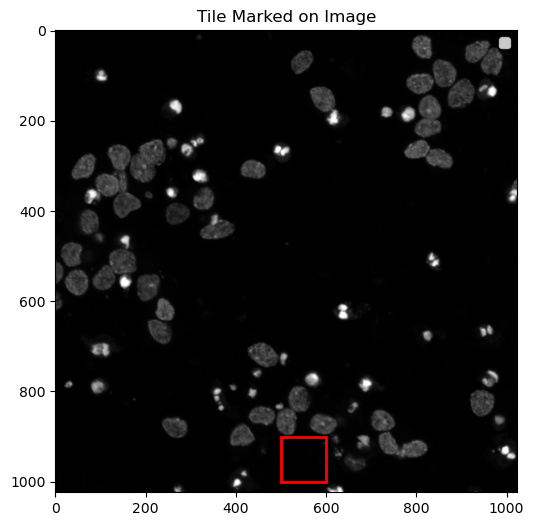

In [187]:
# path = df.Path.iloc[ind]; tile = df.Tile.iloc[ind]
path = '/home/labs/hornsteinlab/Collaboration/FUNOVA/input/images/raw/Batch3/TDP--43-N390D-1005373/panelE/stress/rep1/DAPI/r14c09f85-ch1t1.tiff'
tile_index = 95
print(path, tile_index)
target_path = os.path.join(imgs_path, path)
img = process_tif(target_path)
tiles = crop_image_to_tiles(img, [100, 100])
print(np.shape(tiles))
# show_processed_tif(target_path)
x,y = get_tile_location(tile_index, [img_shape, img_shape], tile_shape)
print(f"Tile {tile_index} is at pixel location: {x,y}")
# Plot the Image with the Marked Tile
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
x,y = get_tile_location(tile_index, [img_shape, img_shape], tile_shape)
plt.gca().add_patch(plt.Rectangle((x, y), tile_shape[0], tile_shape[1], edgecolor='red', linewidth=2, fill=False))
# plt.scatter(x + tile_shape[0] // 2, y + tile_shape[1] // 2,label=f"Tile {tile_index}")  # Mark center
plt.legend()
plt.title("Tile Marked on Image")
plt.show()

In [129]:
tile1 = img[y:y + tile_shape[0], x:x + tile_shape[1]]

In [134]:
get_metrics(tile1, True)

'Brenner: 3.53'

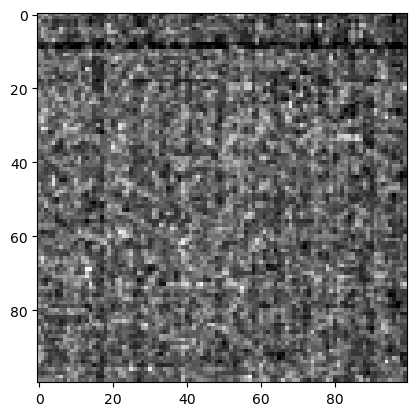

In [167]:
plt.imshow(tile1, cmap='gray')

In [173]:
from skimage.measure import shannon_entropy  

def compute_snr(image: np.ndarray) -> float:
    """
    Compute the Signal-to-Noise Ratio (SNR) of an image.
    
    Args:
        image (np.ndarray): Input grayscale or single-channel image.
    
    Returns:
        float: SNR value.
    """
    signal = np.mean(image)
    noise = np.std(image)
    return 20 * np.log10(signal / noise) if noise > 0 else float("inf")

def compute_entropy(image: np.ndarray) -> float:
    """
    Compute the entropy of an image.
    
    Args:
        image (np.ndarray): Input grayscale or single-channel image.
    
    Returns:
        float: Shannon entropy of the image.
    """
    return shannon_entropy(image)

In [175]:
print("SNR:", compute_snr(tile1))
print("Entropy:", compute_entropy(tile1))

SNR: 8.178361473846547
Entropy: 4.787818897424751


2. Setting Brenners in the csv

In [101]:
## Exp3
# thresholds = {
#     "Nuclear-speckles-SON": (1.8),
#     "DAPI": (1.6),
#     "Stress-initiation": (1.4),
#     "Aberrant-splicing": (2),
#     "mature-Autophagosome": (0),
#     "Cytoskeleton": (2.6),
#     "Ubiquitin-levels": (1),
#     "UPR-ATF4": (3), 
#     "UPR-ATF6": (1.2),
#     "impaired-Autophagosome": (1.8),
#     "Autophagy": (0),
#     "TDP-43": (1),
#     "Parthanatos-late": (0),
#     "Nuclear-speckles-SC35": (0.5),
#     "Splicing-factories": (1.3),
#     "DNA-damage-pH2Ax": (0),
#     "UPR-IRE1a": (5),
#     "Parthanatos-early": (4),
#     "Necrosis": (1.7),
#     "Necroptosis-HMGB1": (7),
#     "DNA-damage-P53BP1": (2.2),
#     "Apoptosis": (0),
#     "Necroptosis-pMLKL": (0),
#     "Protein-degradation": (0),
#     "Senescence-signaling": (0),
#     "Neuronal-activity": (2.4),
# }
## Exp 4 
thresholds = {
    "Nuclear-speckles-SON": (1.8),
    "DAPI": (1.6),
    "Stress-initiation": (1.7),
    "Aberrant-splicing": (2),
    "mature-Autophagosome": (0),
    "Cytoskeleton": (2.6),
    "Ubiquitin-levels": (1),
    "UPR-ATF4": (3), 
    "UPR-ATF6": (1.2),
    "impaired-Autophagosome": (1.8),
    "Autophagy": (0),
    "TDP-43": (0.8),
    "Parthanatos-late": (0),
    "Nuclear-speckles-SC35": (0.6),
    "Splicing-factories": (1),
    "DNA-damage-pH2Ax": (0),
    "UPR-IRE1a": (0.9),
    "Parthanatos-early": (4),
    "Necrosis": (2.2),
    "Necroptosis-HMGB1": (7),
    "DNA-damage-P53BP1": (2.2),
    "Apoptosis": (0),
    "Necroptosis-pMLKL": (1.2),
    "Protein-degradation": (2.2),
    "Senescence-signaling": (0),
    "Neuronal-activity": (1.2),
}

mappings = update_all_mappings(mappings, thresholds)
mappings.to_csv(mappings_filepath)
mappings

,Lower_bound
Aberrant-splicing,2
Apoptosis,0
Autophagy,0
Cytoskeleton,2.6
DAPI,1.6
DNA-damage-P53BP1,2.2
DNA-damage-pH2Ax,0
Necroptosis-HMGB1,7
Necroptosis-pMLKL,1.2
Necrosis,2.2


-----------------------------------------------------